In [1]:
import numpy as np
from typing import List, Tuple
from numpy.typing import ArrayLike
from nn import NeuralNetwork, one_hot_encode_seqs, sample_seqs,read_text_file,read_fasta_file
from sklearn import datasets
from sklearn.model_selection import train_test_split,KFold
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
rap1 = read_text_file("./data/rap1-lieb-positives.txt")
# yeast_neg = read_fasta_file("./data/yeast-upstream-1k-negative.fa")
rap_test = read_text_file("./data/rap1-lieb-test.txt")

In [14]:
np.stack(one_hot_encode_seqs(['AGA']),axis=0)

array([[1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]])

# Sampling Scheme: Upsampling
* I chose to upsample the minority class to keep the dataset large enough to successfuly train a neural network, which needs a lot of data, while keeping the classes balanced. An alternative approach, like downsampling, would have kept 137 positive and 137 negative data points, which would have been a significant reduction in the sample size, possibly leading to a poorly trained model.
* The upsampling procedure is implemented via sampling with replacement of the minority class, while keeping all members of the majority class. In this case, the positive positive Rap1 motifs will be resampled with replacement until there are an equal number of positive and negative motifs (3163 of each)

In [3]:
np.random.seed(42)
#concatenate positive and negative and create a list of labels
seqs = rap1 + rap_test
labels = [True] * len(rap1) + [False]*len(rap_test)

X,y = sample_seqs(seqs,labels,random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = one_hot_encode_seqs(X_train)
X_train = np.stack(X_train,axis=0) #convert list of np arrays back into a 2D array

X_test = one_hot_encode_seqs(X_test)
X_test = np.stack(X_test,axis = 0)

### 5-fold CV Grid Search to find optimal learning rate and activation function hyperparameters


In [4]:
columns = ["lr","activation_layer1","avg_train_error","avg_val_error"] + [f"train_error_fold_{x}" for x in range(1,6)] \
         + [f"val_error_fold_{x}" for x in range(1,6)]            
tuning_results_df = pd.DataFrame(columns = columns)
lrs = [0.01,0.001,0.0001]
activations = ['relu','sigmoid']                                              
kf = KFold(n_splits=5)
df_idx = 0
for lr in lrs:
    for activation_layer1 in activations:
        fold_avg_train_losses = []
        fold_avg_val_losses = []
        for fold_idx, (train,val) in enumerate(kf.split(X_train,y_train)):
            fold_idx = fold_idx + 1
            nn = NeuralNetwork(nn_arch=[{'input_dim': 68, 'output_dim': 16, 'activation': activation_layer1},
                           {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}],
                           lr=lr, batch_size=1, seed=42, epochs=5, loss_function=
                           'cross_entropy') 
            #fit this fold. test data is still held out
            train_loss, val_loss = nn.fit(X_train[train],y_train[train],
                                           X_train[val],y_train[val])
            fold_avg_train_loss = np.mean(train_loss) #avg (across epochs) training loss for this fold
            fold_avg_train_losses.append(fold_avg_train_loss)

            fold_avg_val_loss = np.mean(val_loss) #avg (across epochs) validation loss for this fold
            fold_avg_val_losses.append(fold_avg_val_loss)


            #store hyperparameters and per-fold results
            tuning_results_df.loc[df_idx,"lr"] = lr
            tuning_results_df.loc[df_idx,"activation_layer1"] = activation_layer1
            tuning_results_df.loc[df_idx,f"train_error_fold_{fold_idx}"] = fold_avg_train_loss
            tuning_results_df.loc[df_idx,f"val_error_fold_{fold_idx}"] = fold_avg_val_loss

        #store average train and val loss across all folds for this combination of hyperparameters
        tuning_results_df.loc[df_idx,"avg_train_error"] = np.mean(fold_avg_train_losses)
        tuning_results_df.loc[df_idx,"avg_val_error"] = np.mean(fold_avg_val_losses)

        df_idx +=1

In [5]:
#resulting dataframe stores error from each fold with each combination of hyperparameters
#as well as the average error across all 5 folds with each combnation of hyperparameters
display(tuning_results_df)

,lr,activation_layer1,avg_train_error,avg_val_error,train_error_fold_1,train_error_fold_2,train_error_fold_3,train_error_fold_4,train_error_fold_5,val_error_fold_1,val_error_fold_2,val_error_fold_3,val_error_fold_4,val_error_fold_5
0,0.01,relu,0.280917,0.285548,0.270688,0.282068,0.28026,0.284891,0.286679,0.320527,0.278064,0.287122,0.271489,0.27054
1,0.01,sigmoid,0.441083,0.444449,0.434691,0.441555,0.441875,0.443361,0.443931,0.457451,0.444072,0.439975,0.440672,0.440074
2,0.001,relu,0.600391,0.601669,0.594141,0.601866,0.599978,0.603267,0.602703,0.607028,0.60243,0.599496,0.59858,0.600809
3,0.001,sigmoid,0.69034,0.690329,0.690065,0.690244,0.690148,0.690623,0.69062,0.690454,0.690561,0.69067,0.689742,0.690219
4,0.0001,relu,0.701165,0.701232,0.700776,0.701046,0.701458,0.701599,0.700946,0.702601,0.702182,0.699004,0.699368,0.703007
5,0.0001,sigmoid,0.701553,0.701589,0.7015,0.701408,0.701818,0.70173,0.70131,0.702074,0.702665,0.698771,0.700589,0.703844


In [6]:
#get data for combination of hyperparameters that gave the lowest average binary cross entropy
# across epochs and folds in the validation set
display(tuning_results_df.loc[tuning_results_df['avg_val_error'].astype(float).idxmin()])
best_lr = tuning_results_df.loc[tuning_results_df['avg_val_error'].astype(float).idxmin(),'lr']
best_activation_layer1 = tuning_results_df.loc[tuning_results_df['avg_val_error'].astype(float).idxmin(),'activation_layer1']

print(f"The optimal learning rate was {best_lr}")
print(f"The optimal activation function to use in layer 1 was {best_activation_layer1}")


lr                        0.01
activation_layer1         relu
avg_train_error       0.280917
avg_val_error         0.285548
train_error_fold_1    0.270688
train_error_fold_2    0.282068
train_error_fold_3     0.28026
train_error_fold_4    0.284891
train_error_fold_5    0.286679
val_error_fold_1      0.320527
val_error_fold_2      0.278064
val_error_fold_3      0.287122
val_error_fold_4      0.271489
val_error_fold_5       0.27054
Name: 0, dtype: object

The optimal learning rate was 0.01
The optimal activation function to use in layer 1 was relu


#### Re-training model with optimal set of hyperparameters and plotting per-epoch train and test binary cross entropy

* I chose learning rate and activation function hyperparameters by implementing a cross-validated grid search; the hyperparameters that minimized the average across-fold binary cross entropy on the test set were used moving forward. A subset of samples were completely held out from this procedure to be used for validation/testing here. 
* These results suggest the model was able to learn from the training data and properly generalize to the unseen  data, as the unseen validation loss decreased over the epochs

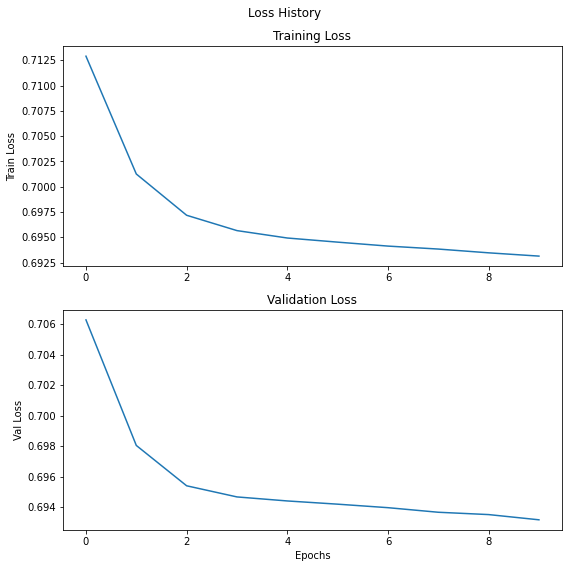

In [7]:
nn = NeuralNetwork(nn_arch=[{'input_dim': 68, 'output_dim': 16, 'activation': activation_layer1},
                           {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}],
                           lr=lr, batch_size=200, seed=42, epochs=10, loss_function=
                           'cross_entropy') 
#X_train and y_train are the same observations that were used for cross validation grid search
#X_test and y_test were completely held out of the grid search procedure
per_epoch_train_loss, per_epoch_val_loss = nn.fit(X_train,y_train,
                                               X_test,y_test)



loss_hist = per_epoch_train_loss
loss_hist_val = per_epoch_val_loss
assert len(loss_hist) > 0, "Need to run training before plotting loss history"
fig, axs = plt.subplots(2, figsize=(8,8))
fig.suptitle('Loss History')
axs[0].plot(np.arange(len(loss_hist)), loss_hist)
axs[0].set_title('Training Loss')
axs[1].plot(np.arange(len(loss_hist_val)), loss_hist_val)
axs[1].set_title('Validation Loss')
plt.xlabel('Epochs')
axs[0].set_ylabel('Train Loss')
axs[1].set_ylabel('Val Loss')
fig.tight_layout()
plt.show() 

### Accuracy of the Classifier on the entire dataset
* Take trained model quantify binary cross entropy error and accuracy on the held out test dataset

In [8]:
predictions = nn.predict(X_test)
test_bce = nn._binary_cross_entropy(y_test,predictions)
print(f"Average binary cross entropy error across held out test data {test_bce}")

#ROC curve
from sklearn.metrics import roc_curve
fpr,tpr,_ = roc_curve(y_test.reshape(y_test.shape[0],1).astype(int),
         predictions)

#to get accuracy, I need to convert binarize predictions, which are given as probabilities
# I will binarize by calling every probability >= 0.5 as 1, and everything <0.5 0
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0
predictions = predictions.astype(int)

y_test = y_test.reshape(y_test.shape[0],1) #reshape to have compatible as predictions
y_test = y_test.astype(int)

test_accuracy = np.sum(predictions==y_test)/len(y_test)
print(f"Test Accuracy: {test_accuracy}")


Average binary cross entropy error across held out test data 0.6933254854237872
Test Accuracy: 0.47652916073968704


No handles with labels found to put in legend.


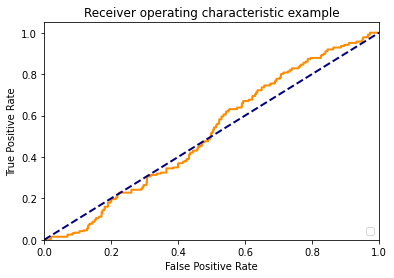

In [9]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [10]:
predictions[predictions>=0.5]=True

In [11]:
predictions

array([[1],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [12]:
predictions = nn.predict(X_train)
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0
predictions = predictions.astype(int)
y_train = y_train.reshape(y_train.shape[0],1) #reshape to have compatible as predictions
y_train = y_train.astype(int)

np.sum(predictions==y_train)/len(y_train)

0.48469983648680215